<a href="https://colab.research.google.com/github/marnixvanbreukelen/Operation_Optimisation/blob/main/Maintenance_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.6 MB/s eta 0:00:00


In [8]:
# Define the column names
index_names = ['unit_number', 'cycle']
# Operational conditions: altitude, mach_number and throttle_resolver_angle
operational_condition_names = ['altitude', 'TRA', 'mach_nr']
sensor_names = ['T2', # total temperature at fan inlet
                'T24',# total temperature at LPC outlet
                'T30', # total temperature at HPC outlet
                'T50', # total temperature at LPT outlet
                'P2', # Pressure at fan inlet
                'P15', #Total pressure in bypass-duct
                'P30', #Total pressure at HPC outlet
                'Nf', #Physical fan speed rpm
                'Nc', #Physical core speed rpm
                'epr', #Engine pressure ratio (P50/P2)
                'Ps30', #Static pressure at HPC outlet
                'phi', #Ratio offuel flow to Ps30
                'NRf', #Corrected fan speed
                'NRc', #Corrected core speed
                'BPR', #Bypass Ratio
                'farB', #Burner fuel-air ratio
                'htBleed', #Bleed Enthalpy
                'Nf_dmd', # Demanded fan speed rpm
                'PCNfR_dmd', #Demanded corrected fan speed rpm
                'W31', #HPT coolant bleed lbm/s
                'W32', #LPT coolant bleed
                ]

column_names = index_names + operational_condition_names + sensor_names

from google.colab import files
uploaded = files.upload()

# Read the CSV file and assign column names
df = pd.read_csv('train_FD001.txt', delim_whitespace=True, header=None, names=column_names)


Saving train_FD001.txt to train_FD001.txt


In [10]:
def add_rul(df):
    # Find the max 'cycle' for each 'unit_number'
    max_cycles = df.groupby('unit_number')['cycle'].transform('max')
    # Calculate RUL
    df['RUL'] = max_cycles - df['cycle']
    return df

df1 = add_rul(df)

In [12]:
def normalize_df_mean(df):
    df_norm_mean = df.copy()  # Create a copy of the DataFrame to avoid modifying the original data
    for column in df.columns:
        std = df[column].std()
        if std == 0:
            df_norm_mean[column] = 0  # If the standard deviation is zero, set all values to zero
        else:
            df_norm_mean[column] = (df[column] - df[column].mean()) / std
    return df_norm_mean

def normalize_min_max(df):
    df_norm_min_max = df.copy()  # Create a copy of the DataFrame to avoid modifying the original data
    for column in df.columns:
        min_val = df[column].min()
        max_val = df[column].max()
        if max_val == min_val:
            df_norm_min_max[column] = 0  # If the min and max are the same, set all values to zero
        else:
            df_norm_min_max[column] = (df[column] - min_val) / (max_val - min_val)
    return df_norm_min_max

In [13]:
y1 = df1['RUL']

X1 = normalize_min_max(df1.drop(['RUL', 'unit_number'], axis=1))   # All values normalized expect for RUL and unit_number

# Y values are the RUL values. Training data engine: 1-79. Testing data engine 80 - 100
y_1_train = y1[df1.unit_number.values < 80]
y_1_test = y1[df1.unit_number.values >= 80]

# X values are the RUL for every unit_number. Training data engine: 1-79. Testing data engine 80 - 100
X1_train = X1.loc[df1.unit_number < 80, :]
X1_test = X1.loc[df1.unit_number >= 80, :]

# Standardizing the features
for col in X1_train.columns:
    if np.std(X1_train[col].values) != 0:
        X1_train.loc[:,col] = (X1_train[col].values - np.mean(X1_train[col].values)) / np.std(X1_train[col].values)
    else:
        X1_train.loc[:,col] = 1
for col in X1_train.columns:
    if np.std(X1_test.loc[:,col].values) != 0:
        X1_test.loc[:,col] = (X1_test[col].values - np.mean(X1_test[col].values)) / np.std(X1_test[col].values)
    else:
        X1_test.loc[:, col] = 1

In [14]:
def RandomForestRegressor_prognostic(X1_train, X1_test, y_1_train, y_1_test):
    rfr = RandomForestRegressor(max_depth=3)
    rfr.fit(X1_train, y_1_train) #Train the model on the training data (fit)
    predictions = rfr.predict(X1_test) # Predicts now y1_test data for X1_test

    # Compute mean error
    errors = predictions - (y_1_test)       #Compare real y_1_test with one predicted from X_1_test
    mean_error = np.mean(np.abs(errors))*400
    print(mean_error)
    return rfr, predictions

In [16]:
def SVR_prognostic(X1_train, X1_test, y_1_train, y_1_test):
    # Initialize and train the SVR model
    svr = SVR(kernel='rbf', C=100, epsilon=0.1)
    svr.fit(X1_train, y_1_train)

    # Predict on the test set
    predictions = svr.predict(X1_test)

    # # Evaluate the model
    # mae = mean_absolute_error(y_1_test, predictions)
    # print(f'Mean Absolute Error: {mae}')
    #
    # # Plot the results
    # plt.scatter(y_1_test, predictions)
    # plt.xlabel('Actual RUL')
    # plt.ylabel('Predicted RUL')
    # plt.title('SVR Prediction vs Actual RUL')
    # plt.show()
    return svr, predictions

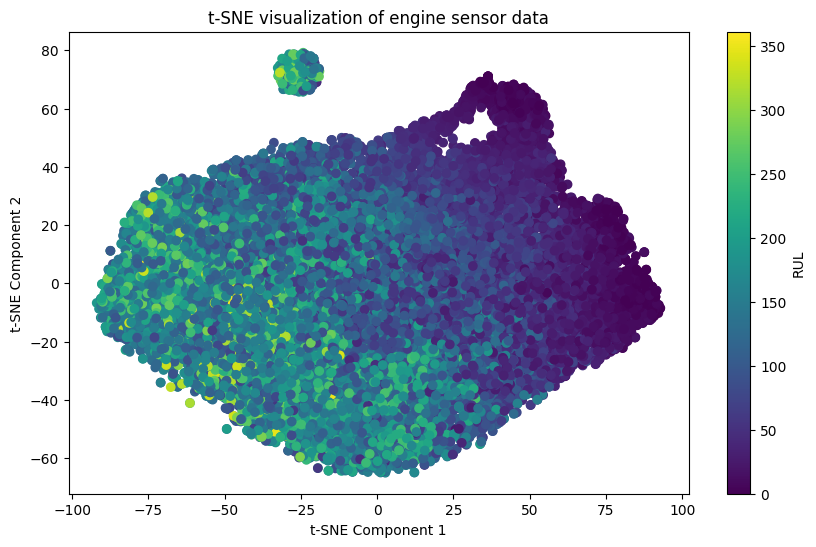

In [17]:
# t-SNE Implementation
def t_SNE_implementation(X1_train, X1_test, y_1_train, y_1_test):
    # Combine train and test data for t-SNE visualization
    X_combined = pd.concat([X1_train, X1_test])
    y_combined = pd.concat([y_1_train, y_1_test])

    # Initialize t-SNE
    tsne = TSNE(n_components=2, random_state=42)

    # Fit and transform the data
    X_tsne = tsne.fit_transform(X_combined)

    # Plot the t-SNE results
    plt.figure(figsize=(10, 6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_combined, cmap='viridis')
    plt.colorbar(label='RUL')
    plt.title('t-SNE visualization of engine sensor data')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()
    return

t_SNE_implementation(X1_train, X1_test, y_1_train, y_1_test)

14598.377021839477


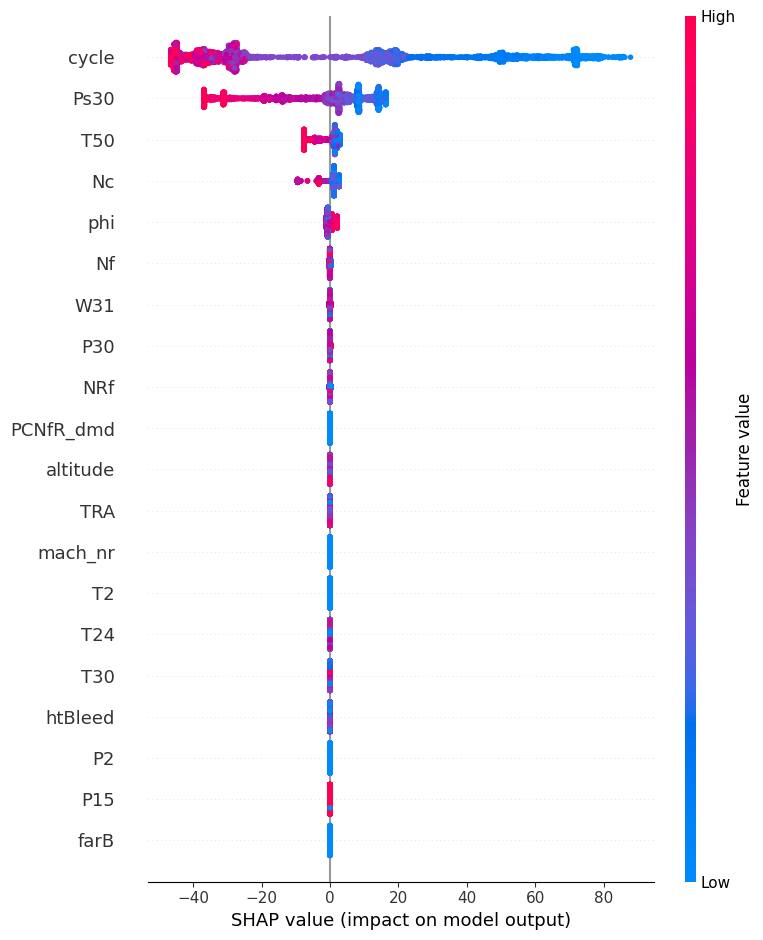

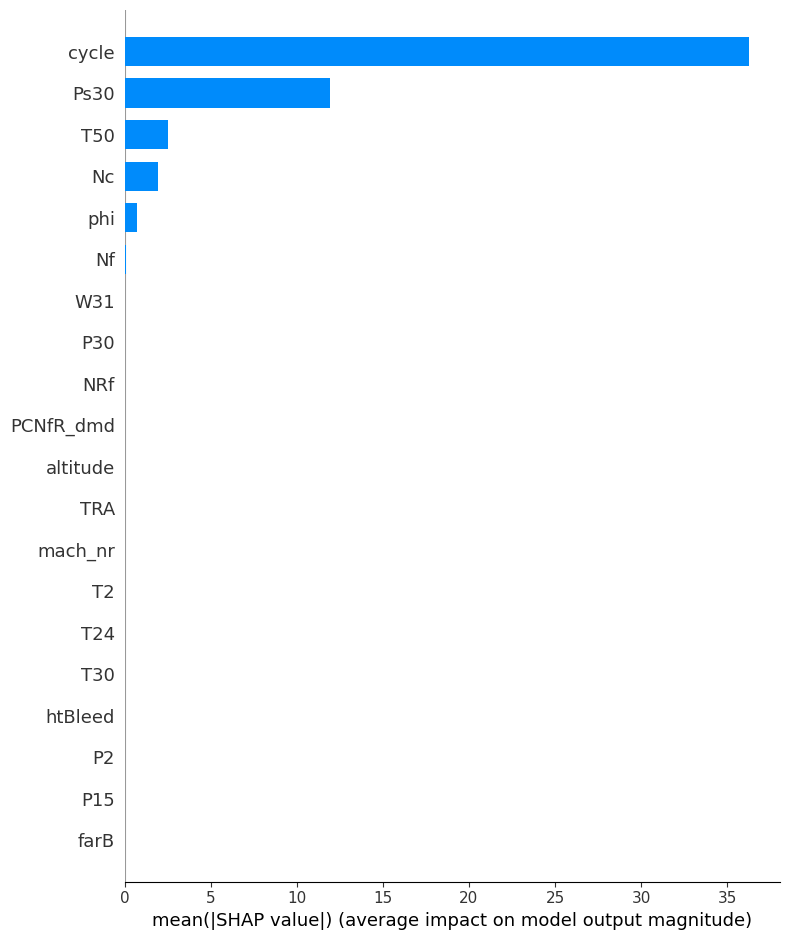

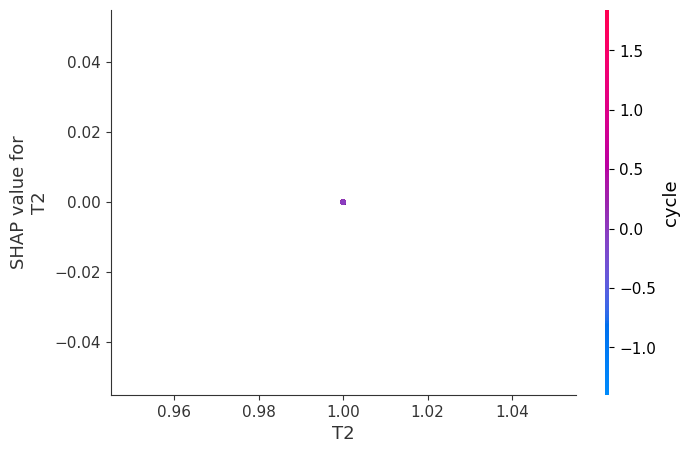

In [19]:
import shap
# This plot should be made without standardization --> thefore comment standardization
def SHAP(X1_train, X1_test, y_1_train, y_1_test):
    # Compute Predictions using RandomForestRegressor
    rfr, predictions = RandomForestRegressor_prognostic(X1_train, X1_test, y_1_train, y_1_test)

    # Initialize the SHAP Explainer
    explainer = shap.Explainer(rfr, X1_train)

    # Calculate SHAP values for the test set
    shap_values = explainer(X1_test)

    # Visualize the SHAP values
    # Summary plot
    shap.summary_plot(shap_values, X1_test)

    # Bar plot for feature importance
    shap.summary_plot(shap_values, X1_test, plot_type="bar")

    # Dependence plot for a specific feature
    shap.dependence_plot("T2", shap_values.values, X1_test)

    # Force plot for the first instance in the test set
    shap.force_plot(explainer.expected_value, shap_values.values[0], X1_test.iloc[0])
    return

SHAP(X1_train, X1_test, y_1_train, y_1_test)


14608.129335312666


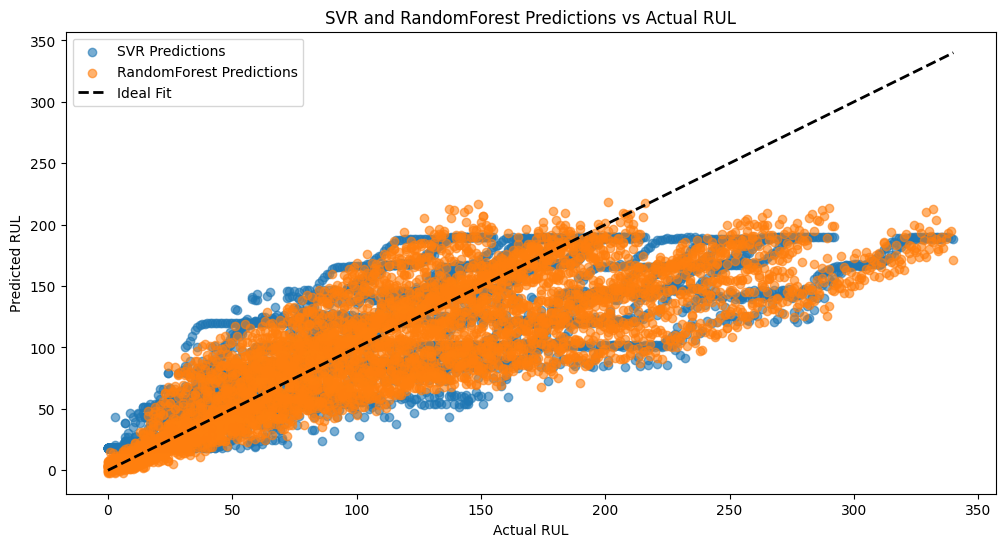

SVR Mean Absolute Error: 34.783417976581724
RandomForestRegressor Mean Absolute Error: 36.52032333828166


In [23]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

def plot_compare_prognostics(X1_train, X1_test, y_1_train, y_1_test):
    rfr, predictions_RFR = RandomForestRegressor_prognostic(X1_train, X1_test, y_1_train, y_1_test)
    svr, predictions_SVR = SVR_prognostic(X1_train, X1_test, y_1_train, y_1_test)

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.scatter(y_1_test, predictions_RFR, label='SVR Predictions', alpha=0.6)
    plt.scatter(y_1_test, predictions_SVR, label='RandomForest Predictions', alpha=0.6)
    plt.plot([y_1_test.min(), y_1_test.max()], [y_1_test.min(), y_1_test.max()], 'k--', lw=2, label='Ideal Fit')
    plt.xlabel('Actual RUL')
    plt.ylabel('Predicted RUL')
    plt.title('SVR and RandomForest Predictions vs Actual RUL')
    plt.legend()
    plt.show()

    mae_svr = mean_absolute_error(y_1_test, predictions_SVR)
    mae_rfr = mean_absolute_error(y_1_test, predictions_RFR)
    print(f'SVR Mean Absolute Error: {mae_svr}')
    print(f'RandomForestRegressor Mean Absolute Error: {mae_rfr}')

    return

plot_compare_prognostics(X1_train, X1_test, y_1_train, y_1_test)



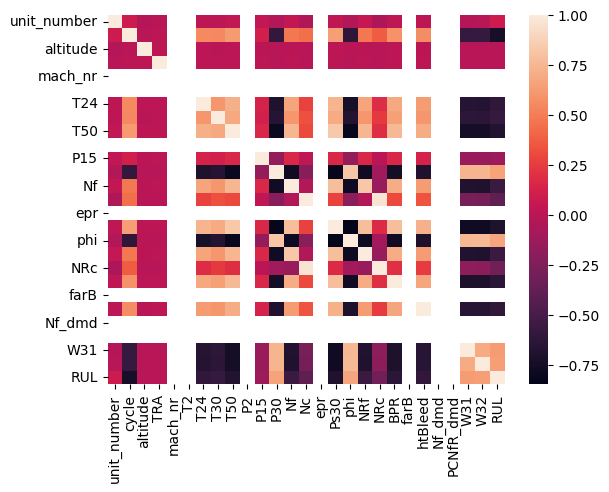

In [26]:
import seaborn as sns

# Heat map input data
def heat_map(df):
    sns.heatmap(df.corr())
    plt.show()
    return
heat_map(df)

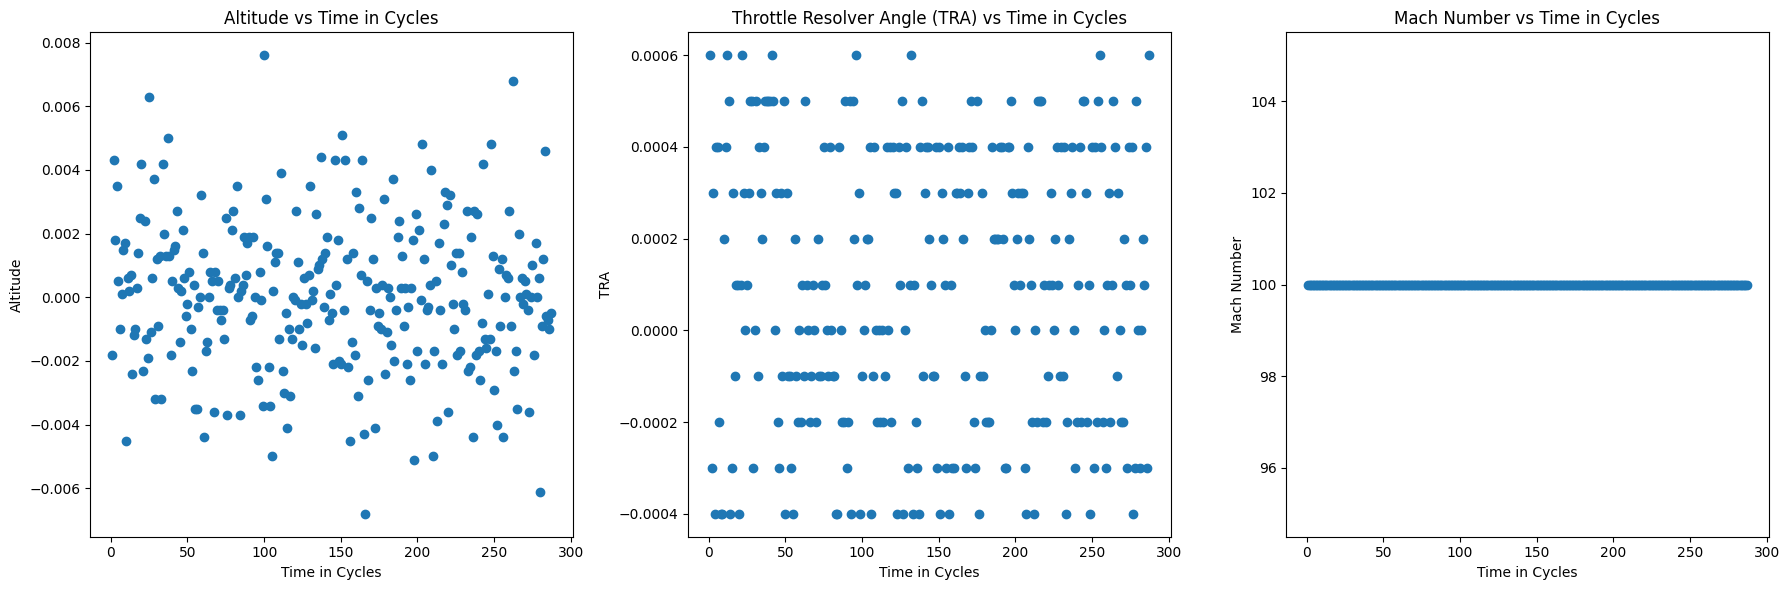

In [29]:
# Operation setting plots
def operation_setting(unit_number, df):
    # Filter the dataframe to only include rows where 'unit_number' is 2
    filtered_df = df[df['unit_number'] == unit_number]
    # Create the plots
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

    # Plot for altitude
    axes[0].scatter(filtered_df['cycle'], filtered_df['altitude'])
    axes[0].set_xlabel('Time in Cycles')
    axes[0].set_ylabel('Altitude')
    axes[0].set_title('Altitude vs Time in Cycles')

    # Plot for throttle resolver angle (TRA)
    axes[1].scatter(filtered_df['cycle'], filtered_df['TRA'])
    axes[1].set_xlabel('Time in Cycles')
    axes[1].set_ylabel('TRA')
    axes[1].set_title('Throttle Resolver Angle (TRA) vs Time in Cycles')

    # Plot for mach number (mach_nr)
    axes[2].scatter(filtered_df['cycle'], filtered_df['mach_nr'])
    axes[2].set_xlabel('Time in Cycles')
    axes[2].set_ylabel('Mach Number')
    axes[2].set_title('Mach Number vs Time in Cycles')

    plt.tight_layout()
    plt.show()
    return

unit_number = 2
operation_setting(unit_number, df)

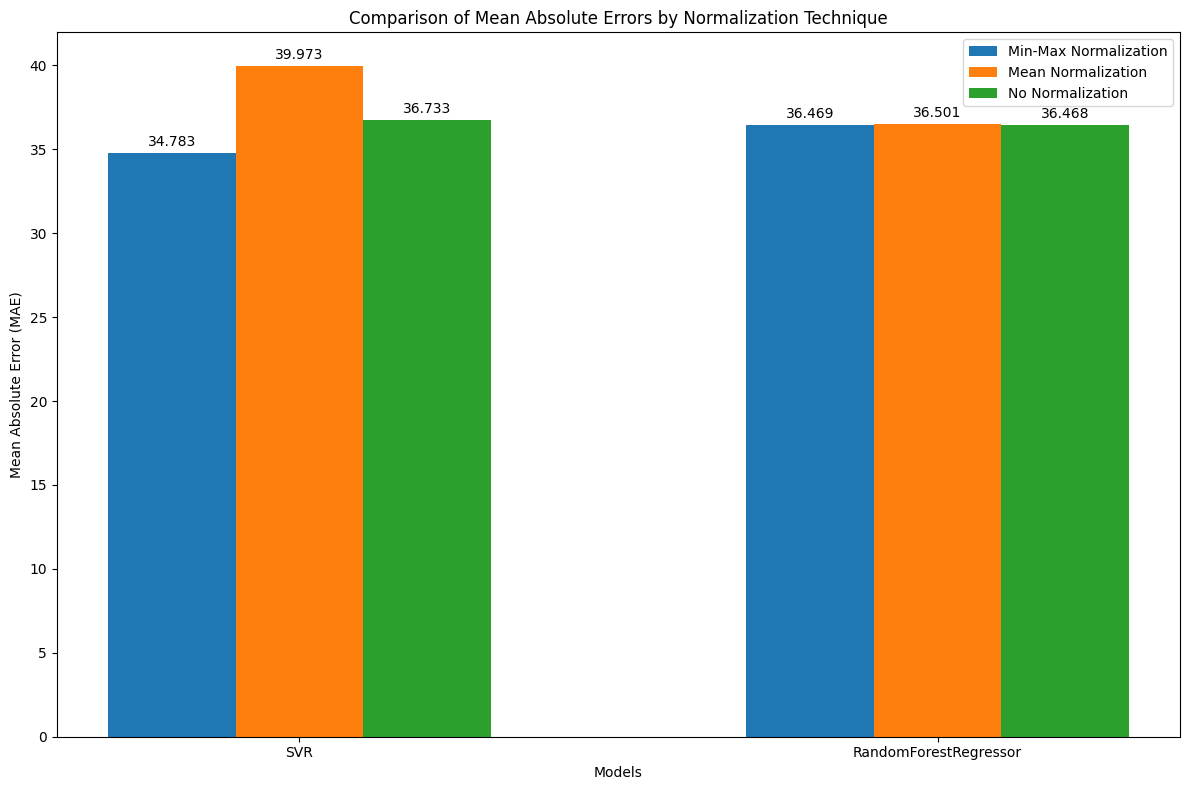

In [31]:
def bar_chart_comparison_prognostic_normalisation():
    # Data
    labels = ['SVR', 'RandomForestRegressor']
    # Errors as provided by prognostic models
    min_max_errors = [34.78341797658171, 36.468929892575325]
    mean_errors = [39.97303623421433, 36.50071840888229]
    no_normalization_errors = [36.73332985444397, 36.46848288317869]

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))

    # Bar width
    bar_width = 0.2

    # Positions of bars on x-axis
    r1 = range(len(labels))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    # Plot bars
    rects1 = ax.bar(r1, min_max_errors, width=bar_width, label='Min-Max Normalization')
    rects2 = ax.bar(r2, mean_errors, width=bar_width, label='Mean Normalization')
    rects3 = ax.bar(r3, no_normalization_errors, width=bar_width, label='No Normalization')

    # Add labels, title, and legend
    ax.set_xlabel('Models')
    ax.set_ylabel('Mean Absolute Error (MAE)')
    ax.set_title('Comparison of Mean Absolute Errors by Normalization Technique')
    ax.set_xticks([r + bar_width for r in range(len(labels))])
    ax.set_xticklabels(labels)
    ax.legend()

    # Add values on top of bars
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height, 3)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    # Show plot
    plt.tight_layout()
    plt.show()

bar_chart_comparison_prognostic_normalisation()